In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('./Data/Alcohol_Sales.csv', index_col='DATE',parse_dates=True)
df.index.freq = 'MS'

<AxesSubplot:xlabel='DATE'>

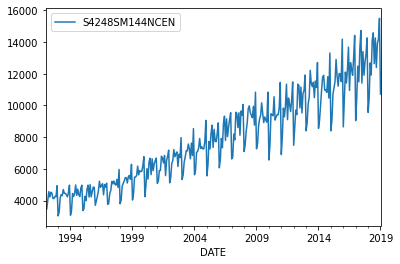

In [3]:
df.plot()

In [4]:
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [5]:
def series_to_supervised(data, n_in, n_out=1):
    cols = list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = pd.concat(cols, axis=1)
    agg.dropna(inplace=True)
    return agg.values

In [6]:
def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

In [7]:
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    train, test = train_test_split(data, n_test)
    model = model_fit(train, cfg)
    history = [x for x in train]
    for i in range(len(test)):
        yhat = model_predict(model, history, cfg)
        predictions.append(yhat)
        history.append(test[i])
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

In [8]:
def repeat_evaluate(data, config, n_test, n_repeats=30):
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

In [9]:
def summarize_scores(name, scores):
    scores_m, score_std = np.mean(scores), np.std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    plt.boxplot(scores)
    plt.show()

In [10]:
def difference(data, interval):
    return [data[i]-data[i-interval] for i in range(interval, len(data))]

In [15]:
def model_fit(train, config):
    return None

In [20]:
def model_predict(model, history, config):
    values = list()
    for offset in config:
        values.append(history[-offset])
    return np.median(values)

In [21]:
config = [12, 24, 36]

In [22]:
data = df.values

In [23]:
n_test = 12

 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
 > 1241.168
persistence: 1241.168 RMSE (+/- 0.000)


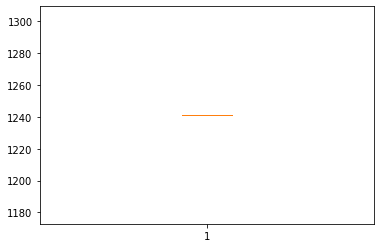

In [24]:
scores = repeat_evaluate(data, config, n_test)
summarize_scores('persistence', scores)

# Multilayer Perceptron Model

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed

In [26]:
def model_fit(train, config):
    n_input, n_nodes, n_epochs, n_batch = config
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    
    inputs = Input(shape=n_input)
    d = Dense(n_nodes, activation='relu')(inputs)
    d = Dense(1)(d)
    model = Model(inputs, d)
    model.compile(loss='mse', optimizer = 'adam')
    model.fit(train_x , train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [27]:
def model_predict(model, history, config):
    n_input, _, _, _ = config
    x_input = np.array(history[-n_input:]).reshape(1, n_input)
    
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

In [28]:
config = [24, 500, 100, 100]

In [29]:
scores = repeat_evaluate(data, config, n_test)

 > 762.314
 > 803.739
 > 735.002
 > 808.263
 > 1015.181
 > 1101.182
 > 663.038
 > 643.677
 > 869.845
 > 967.474
 > 960.725
 > 1133.239
 > 858.241
 > 768.942
 > 696.825
 > 635.172
 > 729.898
 > 919.423
 > 620.862
 > 937.507
 > 821.871
 > 826.297
 > 757.852
 > 1578.290
 > 763.845
 > 698.472
 > 735.257
 > 751.062
 > 1117.466
 > 875.268


mlp: 851.874 RMSE (+/- 193.278)


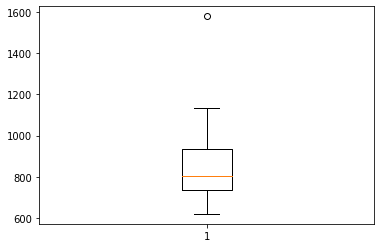

In [30]:
summarize_scores('mlp', scores)

# Convolution Neural Network Model

In [69]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

In [70]:
def model_fit(train, config):
    n_input, n_filters, n_kernel, n_epochs, n_batch = config
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    
    inputs = Input(shape = (n_input, 1))
    c = Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu')(inputs)
    c = MaxPooling1D(pool_size=2)(c)
    c = Flatten()(c)
    c = Dense(1)(c)
    model = Model(inputs, c)
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [71]:
def model_predict(model, history, config):
    n_input, _, _, _, _ = config
    x_input = np.array(history[-n_input:]).reshape((1, n_input, 1))
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

In [72]:
config = [36, 256, 3, 100, 100]

In [73]:
n_test = 12

In [74]:
data = df.values

In [75]:
scores = repeat_evaluate(data, config, n_test)

 > 492.013
 > 948.118
 > 688.748
 > 584.890
 > 687.643
 > 643.710
 > 678.149
 > 525.226
 > 809.647
 > 804.942
 > 492.434
 > 790.257
 > 581.385
 > 638.805
 > 594.656
 > 672.841
 > 568.090
 > 559.760
 > 776.412
 > 748.381
 > 948.060
 > 620.432
 > 600.063
 > 771.273
 > 646.428
 > 656.430
 > 762.986
 > 630.093
 > 520.568
 > 592.543


cnn: 667.833 RMSE (+/- 117.041)


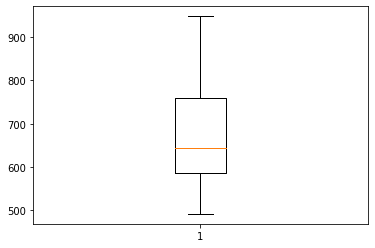

In [76]:
summarize_scores('cnn', scores)

# Recurrent Neural Network Models

## LSTM

In [45]:
def difference(data, interval):
    return [data[i]-data[i-interval] for i in range(interval, len(data))]

In [55]:
def model_fit(train, config):
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    if n_diff > 0:
        train = difference(train, n_diff)
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    inputs = Input(shape=(n_input, 1))
    l = LSTM(n_nodes, activation='relu')(inputs)
    l = Dense(n_nodes, activation='relu')(l)
    l = Dense(1)(l)
    model = Model(inputs, l)
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [56]:
def model_predict(model, history, config):
    n_input, _, _, _, n_diff = config
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    x_input = np.array(history[-n_input:]).reshape((1, n_input, 1))
    yhat = model.predict(x_input, verbose=0)
    return correction + yhat[0]

In [57]:
config = [36, 50, 100, 100, 12]

In [58]:
data = df.values

In [59]:
n_test = 12

In [60]:
scores = repeat_evaluate(data, config, n_test)

 > 528.377
 > 603.719
 > 499.236
 > 597.275
 > 493.661
 > 676.244
 > 542.177
 > 762.639
 > 722.292
 > 583.926
 > 702.874
 > 594.332
 > 512.963
 > 501.296
 > 579.559
 > 641.971
 > 684.355
 > 652.092
 > 665.085
 > 537.101
 > 544.888
 > 550.340
 > 726.573
 > 480.723
 > 686.127
 > 643.619
 > 506.512
 > 424.898
 > 638.214
 > 573.094


lstm: 595.205 RMSE (+/- 83.971)


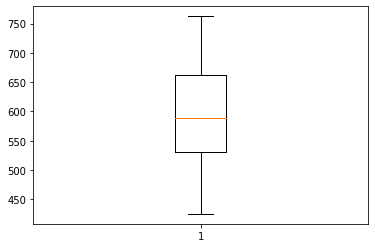

In [61]:
summarize_scores('lstm', scores)

## CNN-LSTM

In [62]:
from tensorflow.keras.layers import TimeDistributed

In [82]:
def model_fit(train, config):
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))
    
    inputs = Input(shape=(None, n_steps, 1))
    c = TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel,
                              activation='relu'))(inputs)
    c = TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel,
                              activation='relu'))(c)
    c = TimeDistributed(MaxPooling1D(pool_size=2))(c)
    c = TimeDistributed(Flatten())(c)
    c = LSTM(n_nodes, activation='relu')(c)
    c = Dense(n_nodes, activation='relu')(c)
    c = Dense(1)(c)
    model = Model(inputs, c)
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [83]:
def model_predict(model, history, config):
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    x_input = np.array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

In [84]:
data = df.values

In [85]:
n_test = 12
config = [3, 12, 64, 3, 100, 200, 100]

In [86]:
scores = repeat_evaluate(data, config, n_test)

 > 474.285
 > 656.116
 > 413.160
 > 367.999
 > 317.412
 > 269.424
 > 394.470
 > 602.582
 > 421.876
 > 377.075
 > 307.921
 > 321.529
 > 354.395
 > 321.798
 > 469.404
 > 462.280
 > 504.587
 > 779.199
 > 529.777
 > 372.223
 > 376.668
 > 453.351
 > 389.525
 > 581.719
 > 422.854
 > 398.650
 > 563.318
 > 512.855
 > 546.505
 > 474.254


cnn-lstm: 447.907 RMSE (+/- 112.058)


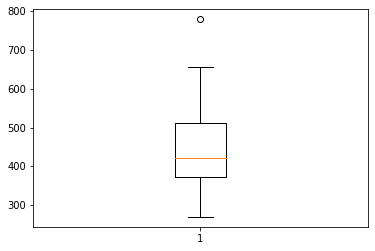

In [87]:
summarize_scores('cnn-lstm', scores)

## ConvLSTM

In [88]:
from tensorflow.keras.layers import ConvLSTM2D

In [89]:
def model_fit(train, config):
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, 1, n_steps, 1))
    
    inputs = Input(shape=(n_seq, 1, n_steps, 1))
    c = ConvLSTM2D(filters=n_filters, kernel_size=(1,n_kernel),
                   activation='relu')(inputs)
    c = Flatten()(c)
    c = Dense(n_nodes, activation='relu')(c)
    c = Dense(1)(c)
    model = Model(inputs, c)
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [90]:
def model_predict(model, history, config):
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    x_input = np.array(history[-n_input:]).reshape((1, n_seq, 1, n_steps, 1))
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

In [91]:
config = [3, 12, 256, 3, 200, 200, 100]
n_test = 12

In [92]:
scores = repeat_evaluate(data, config, n_test)

 > 315.606
 > 464.011
 > 251.904
 > 391.469
 > 388.319
 > 284.681
 > 264.076
 > 475.540
 > 303.668
 > 574.203
 > 237.698
 > 335.048
 > 419.378
 > 314.688
 > 303.481
 > 281.867
 > 360.165
 > 340.300
 > 405.087
 > 183.557
 > 395.009
 > 216.486
 > 266.876
 > 435.886
 > 347.082
 > 287.909
 > 281.383
 > 344.633
 > 294.923
 > 353.454


convlstm: 337.279 RMSE (+/- 82.539)


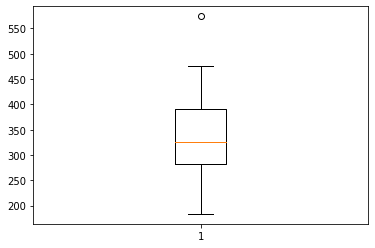

In [93]:
summarize_scores('convlstm', scores)